#Предобработка

####Импортируем библиотеки:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data as t_data
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from torchvision import transforms
from torchsummary import summary
import torch.nn.functional as F
from pathlib import Path
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


####Загрузим датасет и подключим даталоадер:

Подключение drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
!unzip -q "/content/gdrive/My Drive/P2S/Dataset.zip"

In [ ]:
!ls Dataset/

testArts  testPictures	trainArts  trainPictures


In [ ]:
class dataset(Dataset):
  def __init__(self, files, mode):
    self.files = sorted(files)
    self.len_ = len(self.files)
    self.mode = mode

  def __len__(self):
    return self.len_

  def load_sample(self, file):
    image = Image.open(file).convert('RGB')
    image.load()
    return image

  def __getitem__(self, index):
    x = self.load_sample(self.files[index])
    if self.mode == "train":
      t = transforms.Compose([
              transforms.RandomHorizontalFlip(),
              transforms.RandomRotation(20),
              transforms.RandomVerticalFlip(),
              transforms.Resize((512, 512)),
              transforms.ToTensor(),
              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                        
      ])
      x = t(x)
    else:
      t = transforms.Compose([
                              transforms.Resize((512, 512)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])
      x = t(x)

    return x


In [ ]:
TRAINART_DIR = Path("Dataset/trainArts")
TRAINPIC_DIR = Path("Dataset/trainPictures")
TESTART_DIR = Path("Dataset/testArts")
TESTPIC_DIR = Path("Dataset/testPictures")

train_arts_files = list(TRAINART_DIR.rglob('*.jpg'))
train_pictures_files = list(TRAINPIC_DIR.rglob('*.jpg'))
test_arts_files = list(TESTART_DIR.rglob('*.jpg'))
test_pictures_files = list(TESTPIC_DIR.rglob('*.jpg'))

arts_dataset = dataset(train_arts_files, mode="train")
pictures_dataset = dataset(train_pictures_files, mode="train")
arts_testdataset = dataset(test_arts_files, mode="test")
pictures_testdataset = dataset(test_pictures_files, mode="test")

batch_size = 3

data_train_arts = DataLoader(arts_dataset, batch_size=batch_size, shuffle=True)
data_train_pictures = DataLoader(pictures_dataset, batch_size=batch_size, shuffle=True)
data_test_arts = DataLoader(arts_testdataset, batch_size=batch_size, shuffle=True)
data_test_pictures = DataLoader(pictures_testdataset, batch_size=batch_size, shuffle=True)


In [ ]:
def imshow(array, first=None):
  if first == None:
    try:
      array = (array.detach() + 1) / 2 
    except:
      pass
    array = np.transpose(array.detach().cpu().numpy(),(1, 2, 0))
    plt.imshow(array,cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.show()

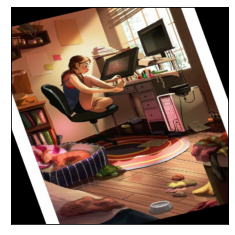

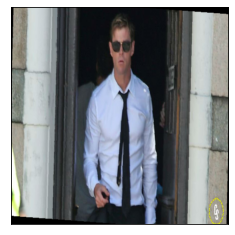

In [ ]:
art = next(iter(data_train_arts))
picture = next(iter(data_train_pictures))
imshow(art.data.cpu()[0])
imshow(picture.data.cpu()[0])

#Модели

####Residual block:

In [ ]:
class ResidualBlock2(nn.Module):
  def __init__(self, in_dim):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_dim, in_dim, kernel_size=3, padding=1),
        nn.InstanceNorm2d(in_dim),
        nn.ReLU()
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_dim, in_dim, kernel_size=3, padding=1),
        nn.InstanceNorm2d(in_dim),
        nn.ReLU()
    )    
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_dim, in_dim, kernel_size=3, padding=1),
        nn.InstanceNorm2d(in_dim),
    )
  def forward(self, x):
    r1 = self.conv1(x)
    r2 = self.conv2(r1)
    r3 = self.conv3(r2)
    return r3 + 0.3 * x

class ResidualBlock4x2(nn.Module):
  def __init__(self, in_dim, out_dim):
    super().__init__()
    self.rb1 = nn.Sequential(
        ResidualBlock2(in_dim),
        nn.InstanceNorm2d(in_dim),
        nn.ReLU()
    )
    self.rb2 = nn.Sequential(
        ResidualBlock2(in_dim),
        nn.InstanceNorm2d(in_dim),
        nn.ReLU()
    )
    self.rb3 = nn.Sequential(
        ResidualBlock2(in_dim),
        nn.InstanceNorm2d(in_dim),
        nn.ReLU()
    )
    self.rb4 = nn.Sequential(
        ResidualBlock2(in_dim),
        nn.InstanceNorm2d(in_dim),
    )
  def forward(self, x):
    b1 = self.rb1(x)
    b2 = self.rb2(b1)
    b3 = self.rb3(b2)
    b4 = self.rb4(b3)
    res = b4 + 0.7 * x
    return res   
    


####Generator

In [ ]:
class generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.enc1 = nn.Sequential(#512x512
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
        nn.InstanceNorm2d(16),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.InstanceNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1),
        nn.InstanceNorm2d(32),
        nn.ReLU()
    )
    self.enc2 = nn.Sequential(#256x256
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.InstanceNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
        nn.InstanceNorm2d(64), 
        nn.ReLU()
    )
    self.enc3 = nn.Sequential(#128x128
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.InstanceNorm2d(128), 
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
        nn.InstanceNorm2d(128),
        nn.ReLU()
    )
    self.enc4 = nn.Sequential(#64x64
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.InstanceNorm2d(256), 
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1),
        nn.InstanceNorm2d(256),
        nn.ReLU()
    )
    self.enc5 = nn.Sequential(#32x32
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
        nn.InstanceNorm2d(512), 
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1),
        nn.InstanceNorm2d(512),
        nn.ReLU()
    )
    self.rb = nn.Sequential(
        ResidualBlock4x2(512, 512),
        ResidualBlock4x2(512, 512),
        ResidualBlock4x2(512, 512)
    )
    self.dec1 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=1024, out_channels=256, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(256)
    )
    self.dec2 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=512, out_channels=128, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(128)
    )
    self.dec3 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(64)
    )
    self.dec4 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(32),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.InstanceNorm2d(32)
    )
    self.dec5 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1),
        nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1)
    )
    
  def forward(self, x):
    e1 = self.enc1(x)
    e2 = self.enc2(e1)
    e3 = self.enc3(e2)
    e4 = self.enc4(e3)
    e5 = self.enc5(e4)
    rb = self.rb(e5)
    d1 = F.relu(self.dec1(torch.cat((rb, e5), dim=1)))
    d2 = F.relu(self.dec2(torch.cat((d1, e4), dim=1)))
    d3 = F.relu(self.dec3(d2))
    d4 = F.relu(self.dec4(d3))
    d5 = torch.tanh(self.dec5(d4))
    return d5




In [ ]:
summary(generator().to(device), (3, 512, 512), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [3, 16, 512, 512]             448
    InstanceNorm2d-2          [3, 16, 512, 512]               0
              ReLU-3          [3, 16, 512, 512]               0
            Conv2d-4          [3, 32, 512, 512]           4,640
    InstanceNorm2d-5          [3, 32, 512, 512]               0
              ReLU-6          [3, 32, 512, 512]               0
            Conv2d-7          [3, 32, 256, 256]           9,248
    InstanceNorm2d-8          [3, 32, 256, 256]               0
              ReLU-9          [3, 32, 256, 256]               0
           Conv2d-10          [3, 64, 256, 256]          18,496
   InstanceNorm2d-11          [3, 64, 256, 256]               0
             ReLU-12          [3, 64, 256, 256]               0
           Conv2d-13          [3, 64, 128, 128]          36,928
   InstanceNorm2d-14          [3, 64, 1

####Discriminator

In [ ]:
class discriminator (nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Sequential(nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1),
                                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                nn.Conv2d(in_channels=64,out_channels=64,kernel_size=4,stride=2,padding=1),
                                nn.InstanceNorm2d(64))
        self.conv2=nn.Sequential(nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
                                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                nn.Conv2d(in_channels=128,out_channels=128,kernel_size=4,stride=2,padding=1),
                                nn.InstanceNorm2d(128))
        self.conv3=nn.Sequential(nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
                                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                nn.Conv2d(in_channels=256,out_channels=256,kernel_size=4,stride=2,padding=1),
                                nn.InstanceNorm2d(256))
        self.conv4=nn.Sequential(nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1),
                                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                nn.Conv2d(in_channels=512,out_channels=512,kernel_size=4,stride=2,padding=1),
                                nn.InstanceNorm2d(512))
        self.conv5=nn.Sequential(nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),
                                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                nn.Conv2d(in_channels=512,out_channels=512,kernel_size=4,stride=2,padding=1),
                                nn.InstanceNorm2d(512))
        self.conv6=nn.Sequential(nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),
                                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                nn.Conv2d(in_channels=512,out_channels=512,kernel_size=4,stride=2,padding=1),
                                nn.InstanceNorm2d(512))
        self.out=nn.Sequential(nn.Conv2d(512,1,4,1))

        self.avg=nn.AdaptiveAvgPool2d(1)

    def forward(self,x):
        c1=F.leaky_relu(self.conv1(x),negative_slope=0.2, inplace=True)
        c2=F.leaky_relu(self.conv2(c1),negative_slope=0.2, inplace=True)
        c3=F.leaky_relu(self.conv3(c2),negative_slope=0.2, inplace=True)
        c4=F.leaky_relu(self.conv4(c3),negative_slope=0.2, inplace=True)
        c5=F.leaky_relu(self.conv5(c4),negative_slope=0.2, inplace=True)
        c6=F.leaky_relu(self.conv6(c5),negative_slope=0.2, inplace=True)
        res=self.avg(self.out(c6))
        return torch.squeeze(torch.squeeze(res, 2), 2)
         

In [ ]:
summary(discriminator().to(device), (3, 512, 512), batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [3, 64, 512, 512]           1,792
         LeakyReLU-2          [3, 64, 512, 512]               0
            Conv2d-3          [3, 64, 256, 256]          65,600
    InstanceNorm2d-4          [3, 64, 256, 256]               0
            Conv2d-5         [3, 128, 256, 256]          73,856
         LeakyReLU-6         [3, 128, 256, 256]               0
            Conv2d-7         [3, 128, 128, 128]         262,272
    InstanceNorm2d-8         [3, 128, 128, 128]               0
            Conv2d-9         [3, 256, 128, 128]         295,168
        LeakyReLU-10         [3, 256, 128, 128]               0
           Conv2d-11           [3, 256, 64, 64]       1,048,832
   InstanceNorm2d-12           [3, 256, 64, 64]               0
           Conv2d-13           [3, 512, 64, 64]       1,180,160
        LeakyReLU-14           [3, 512,

#Обучение

####Создадим модели

In [ ]:
p2a = generator().to(device)
a2p = generator().to(device)

da = discriminator().to(device)
dp = discriminator().to(device)
lr = 0.0002

artLoss = nn.MSELoss()
p2aoptim = optim.RMSprop(p2a.parameters(), lr=lr, eps=1e-06)

photoLoss = nn.MSELoss()
a2poptim = optim.RMSprop(a2p.parameters(), lr=lr, eps=1e-06)

daLoss = nn.MSELoss()
daoptim = optim.RMSprop(da.parameters(), lr=lr, eps=1e-06)

dpLoss = nn.MSELoss()
dpoptim = optim.RMSprop(dp.parameters(), lr=lr, eps=1e-06)


epochs = 3000
printing_steps = 1
filepath = "/content/gdrive/My Drive/P2S/model/"

####Загрузим модель после реконекта колаба :)

In [ ]:
state = torch.load(filepath + "p2a" + '.pt')
p2a.load_state_dict(state['state_dict'])
p2aoptim.load_state_dict(state['optimizer'])

state = torch.load(filepath + "a2p" + '.pt')
a2p.load_state_dict(state['state_dict'])
a2poptim.load_state_dict(state['optimizer'])

state = torch.load(filepath + "da" + '.pt')
da.load_state_dict(state['state_dict'])
daoptim.load_state_dict(state['optimizer'])

state = torch.load(filepath + "dp" + '.pt')
dp.load_state_dict(state['state_dict'])
dpoptim.load_state_dict(state['optimizer'])


In [ ]:
print(data_train_arts.shape, data_train_pictures.shape)

AttributeError: ignored

####Приступим к обучению

In [ ]:
for epoch in range(epochs):
  count = 0
  d1Loss = 0
  d2Loss = 0
  g1Loss = 0
  g2Loss = 0
  cLoss = 0
  accd1 = 0
  accd2 = 0

  for Arts, Photos in zip(data_train_arts, data_train_pictures):
    if(Arts.shape[0] != batch_size or Photos.shape[0] != batch_size):
      continue
    count += 1
    #train discriminators
    da.train()
    dp.train()
    a2p.train(False)
    p2a.train(False)
    for param in da.parameters():
      param.requires_grad = True
    for param in dp.parameters():
      param.requires_grad = True

    inp_real_art = Arts
    inp_real_art = torch.Tensor(inp_real_art.reshape(batch_size, 3, 512, 512)).to(device)

    inp_real_photo = Photos
    inp_real_photo = torch.Tensor(inp_real_photo.reshape(batch_size, 3, 512, 512)).to(device)

    dis_real_art = da(inp_real_art)
    dis_real_artloss = daLoss(dis_real_art, 
                           torch.ones(batch_size, 1).to(device))
    
    dis_real_photo = dp(inp_real_photo)
    dis_real_photoloss = dpLoss(dis_real_photo, 
                                torch.ones(batch_size, 1).to(device))
    
    inp_fake_art = p2a(inp_real_photo)
    dis_fake_art = da(inp_fake_art)
    dis_fake_artloss = daLoss(dis_fake_art, 
                              torch.zeros(batch_size, 1).to(device))
    inp_fake_photo = a2p(inp_real_art)
    dis_fake_photo = dp(inp_fake_photo)
    dis_fake_photoloss = dpLoss(dis_fake_photo, 
                                torch.zeros(batch_size, 1).to(device))                  
    
    art_loss = dis_real_artloss + dis_fake_artloss
    photo_loss = dis_real_photoloss + dis_fake_photoloss

    d1Loss += art_loss
    d2Loss += photo_loss
    accd1 += F.l1_loss(dis_real_art, torch.ones(batch_size, 1).to(device)) + F.l1_loss(dis_fake_art, torch.zeros(batch_size, 1).to(device))

    accd2 += F.l1_loss(dis_real_photo, torch.ones(batch_size, 1).to(device)) + F.l1_loss(dis_fake_photo, torch.zeros(batch_size, 1).to(device))

    dp.zero_grad()
    da.zero_grad()

    art_loss.backward()
    photo_loss.backward()

    daoptim.step()
    dpoptim.step()

    for param in da.parameters():
      param.requires_grad = False
    for param in dp.parameters():
      param.requires_grad = False
    
    #train generators
    a2p.train()
    p2a.train()
    da.train(False)
    dp.train(False)

    for param in a2p.parameters():
      param.requires_grad = True
    for param in p2a.parameters():
      param.requires_grad = True

    inp_real_art = Arts
    inp_real_art = torch.Tensor(inp_real_art.reshape(batch_size, 3, 512, 512)).to(device)

    inp_real_photo = Photos
    inp_real_photo = torch.Tensor(inp_real_photo.reshape(batch_size, 3, 512, 512)).to(device)   

    photo_fake = a2p(inp_real_art)
    art_fake = p2a(inp_real_photo)

    dis_photo = dp(photo_fake)
    dis_art = da(art_fake)

    art_loss = artLoss(dis_photo, torch.ones(batch_size, 1).to(device))
    photo_loss = photoLoss(dis_art, torch.ones(batch_size, 1).to(device))

    g1Loss += art_loss
    g2Loss += photo_loss
    generators_loss = art_loss + photo_loss

    art_cycle = p2a(photo_fake)
    photo_cycle = a2p(art_fake)

    art_cycle_loss = F.l1_loss(art_cycle, inp_real_art)
    photo_cycle_loss = F.l1_loss(photo_cycle, inp_real_photo)

    loss_cycle = 10 * (art_cycle_loss + photo_cycle_loss)
    cLoss = loss_cycle
    loss = generators_loss + loss_cycle
    a2p.zero_grad()
    p2a.zero_grad()
    loss.backward()
    a2poptim.step()
    p2aoptim.step()

    for param in a2p.parameters():
      param.requires_grad = False
    for param in p2a.parameters():
      param.requires_grad = False

  if epoch%printing_steps==0:
        a2p.eval()
        p2a.eval()
        accd1 /= count
        accd2 /= count
        print ("%d [Ds: %f, Dw: %f| accuracy: summer: %f, winter: %f] [Gs2w: %f Gw2s: %f Gcycle %f]" % (epoch, d1Loss, d2Loss, accd1, accd2, g1Loss, g2Loss, cLoss))
        savec()
        state = {
            'epoch': epoch,
            'state_dict': da.state_dict(),
            'optimizer': daoptim.state_dict()
        }
        torch.save(state, filepath + "da" + '.pt')

        state = {
            'epoch': epoch,
            'state_dict': dp.state_dict(),
            'optimizer': dpoptim.state_dict()
        }
        torch.save(state, filepath + "dp"  + '.pt')

        state = {
            'epoch': epoch,
            'state_dict': a2p.state_dict(),
            'optimizer': a2poptim.state_dict()
        }
        torch.save(state, filepath + "a2p" + '.pt')

        state = {
            'epoch': epoch,
            'state_dict': p2a.state_dict(),
            'optimizer': p2aoptim.state_dict()
        }
        torch.save(state, filepath + "p2a"  + '.pt')
        
        print("\n\n")





0 [Ds: 0.021079, Dw: 0.019735| accuracy: summer: 0.025455, winter: 0.015193] [Gs2w: 54.951561 Gw2s: 55.031002 Gcycle 1.312319]



1 [Ds: 0.023014, Dw: 0.348552| accuracy: summer: 0.022984, winter: 0.030763] [Gs2w: 54.731529 Gw2s: 55.000458 Gcycle 1.547050]



2 [Ds: 0.038364, Dw: 3.500055| accuracy: summer: 0.022402, winter: 0.143228] [Gs2w: 53.919350 Gw2s: 55.016335 Gcycle 1.335266]



3 [Ds: 0.000160, Dw: 2.986881| accuracy: summer: 0.001836, winter: 0.142312] [Gs2w: 53.272255 Gw2s: 55.000759 Gcycle 1.606009]



4 [Ds: 0.027260, Dw: 4.127449| accuracy: summer: 0.019814, winter: 0.183423] [Gs2w: 53.150715 Gw2s: 55.010990 Gcycle 1.543074]



5 [Ds: 0.022725, Dw: 2.390527| accuracy: summer: 0.022485, winter: 0.126541] [Gs2w: 52.710068 Gw2s: 54.999557 Gcycle 1.889797]



6 [Ds: 0.021780, Dw: 3.867251| accuracy: summer: 0.026939, winter: 0.188961] [Gs2w: 53.437405 Gw2s: 55.032524 Gcycle 1.611524]



7 [Ds: 0.024469, Dw: 3.210474| accuracy: summer: 0.028580, winter: 0.150512] [Gs2w: 53.221

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).





11 [Ds: 0.024540, Dw: 2.768302| accuracy: summer: 0.022878, winter: 0.132255] [Gs2w: 53.180309 Gw2s: 55.000401 Gcycle 1.541320]



12 [Ds: 0.031093, Dw: 2.251373| accuracy: summer: 0.019788, winter: 0.112450] [Gs2w: 53.163548 Gw2s: 55.028114 Gcycle 1.528561]



13 [Ds: 0.003682, Dw: 2.662823| accuracy: summer: 0.006821, winter: 0.128289] [Gs2w: 53.866421 Gw2s: 55.002140 Gcycle 1.455138]



14 [Ds: 0.026310, Dw: 2.209133| accuracy: summer: 0.026093, winter: 0.134874] [Gs2w: 53.446896 Gw2s: 54.973396 Gcycle 1.664580]



15 [Ds: 0.026228, Dw: 0.855519| accuracy: summer: 0.028248, winter: 0.068418] [Gs2w: 54.493355 Gw2s: 55.049236 Gcycle 1.778876]



16 [Ds: 0.022809, Dw: 2.443376| accuracy: summer: 0.026096, winter: 0.117477] [Gs2w: 53.003674 Gw2s: 54.986500 Gcycle 1.406975]



17 [Ds: 0.019031, Dw: 3.706928| accuracy: summer: 0.024666, winter: 0.160810] [Gs2w: 53.752903 Gw2s: 55.028435 Gcycle 1.411530]



18 [Ds: 0.021064, Dw: 2.982257| accuracy: summer: 0.026072, winter: 0.141921] [G

####Отобразим картинки

In [ ]:
import os
os.getcwd()
os.chdir('/content/gdrive/My Drive/P2S/')

In [ ]:

os.getcwd()

'/content/gdrive/My Drive/P2S'

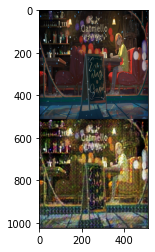

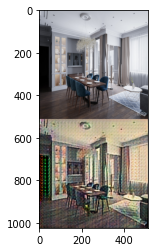

In [ ]:
def savec():
  import cv2
  x = next(iter(data_test_arts))
  a2p.eval()
  p2a.eval()
  y = (a2p(torch.Tensor(x).to(device)))
  x = x[0].numpy()
  x = (np.transpose(x, (1, 2, 0)) + 1)/2
  y = y.detach().cpu().numpy()
  y = y[0]
  y = (np.transpose(y, (1, 2, 0)) + 1)/2
  im_v = cv2.vconcat([x, y]).transpose((2, 0, 1))
  
  im_v = im_v.transpose((1, 2, 0))
  fig, axs = plt.subplots(1, 1)
  axs.imshow(im_v,cmap='binary')
  fig.show()
  fig.savefig("images/a2p.jpg")

  x = next(iter(data_test_pictures))
  y = (p2a(torch.Tensor(x).to(device)) )
  x = x[0].numpy()
  y = y[0]
  x = (np.transpose(x, (1, 2, 0)) + 1)/2
  y = y.detach().cpu().numpy()
  y = (np.transpose(y, (1, 2, 0)) + 1)/2
  im_v = cv2.vconcat([x, y]).transpose((2, 0, 1))
  
  im_v = im_v.transpose((1, 2, 0))
  fig, axs = plt.subplots(1, 1)
  axs.imshow(im_v,cmap='binary')
  fig.show()
  fig.savefig("images/p2a.jpg")  

savec()

In [ ]:
        filepath = os.getcwd() + "/model/"
        state = {
            'epoch': epoch,
            'state_dict': da.state_dict(),
            'optimizer': daoptim.state_dict()
        }
        torch.save(state, filepath + "da" + '.pt')

        state = {
            'epoch': epoch,
            'state_dict': dp.state_dict(),
            'optimizer': dpoptim.state_dict()
        }
        torch.save(state, filepath + "dp"  + '.pt')

        state = {
            'epoch': epoch,
            'state_dict': a2p.state_dict(),
            'optimizer': a2poptim.state_dict()
        }
        torch.save(state, filepath + "a2p" + '.pt')

        state = {
            'epoch': epoch,
            'state_dict': p2a.state_dict(),
            'optimizer': p2aoptim.state_dict()
        }
        torch.save(state, filepath + "p2a"  + '.pt')